In [1]:
import sys
sys.path.insert(0, "../")

import os
import operator
import logging as logger
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table
from tqdm import tqdm
from time import time

from mcfa.mcfa import MCFA

%matplotlib inline

In [2]:
galah = Table.read("../catalogs/GALAH_DR2.1_catalog.fits")

In [3]:
# Get some subset of the data
N = 10000 # subsample the data for testing
np.random.seed(42)

D = 15
element_label_names = [ln for ln in galah.dtype.names if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_"))]

# Select a subset of stars and abundances
is_ok = dict()
for label_name in element_label_names:
    is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)
    
use_element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]][:D - 1]

# Add in Eu.
use_element_label_names.append("eu_fe")

meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    
use_element_label_names.append("fe_h")
    


X = np.array([galah[ln][meets_qc] for ln in use_element_label_names]).T

if N is not None and N < X.shape[0]:    
    print("Sub-sampling {} stars (from {})".format(N, X.shape[0]))
    idx = np.random.choice(X.shape[0], N, replace=False)
    X = X[idx]
    
else:
    idx = np.arange(sum(meets_qc))
    

fe_h_index = list(use_element_label_names).index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    X[:, d] += X[:, fe_h_index]
    
    
label_names = np.array(["{}_h".format(ea.split("_")[0]) for ea in use_element_label_names])
    
N, D = X.shape
assert N > D
assert np.all(np.isfinite(X))

264227


In [4]:

print(N, D)

# Do some grid search in J, K
Js = np.arange(1, 10 + 1).astype(int)
Ks = np.arange(1, 30 + 1).astype(int)

# TODO: Should we use some approximation to estimate how long it will take?

BICs = np.nan * np.ones((Js.size, Ks.size))
opt_times = np.nan * np.ones((Js.size, Ks.size))
log_likelihoods = np.nan * np.ones((Js.size, Ks.size))

write_results = True
results_path = "results/galah-gridsearch-J{J}-K{K}.pkl"

results_folder = os.path.dirname(results_path)
if not os.path.exists(results_folder):
    os.mkdir(results_folder)

mcfa_kwds = dict(max_iter=1000, n_init=5, tol=1e-5, verbose=0,
                 random_seed=None)

7984 16


In [5]:
c, C = (0, Js.size * Ks.size)

for k, K in enumerate(Ks):
    for j, J in enumerate(Js):
        
        c += 1
        print("{}/{}: J = {}, K = {}".format(c, C, J, K))
        if np.isfinite(BICs[j, k]):
            print("Skipping..")
            continue
        
        kwds = mcfa_kwds.copy()
        kwds.update(n_components=K, n_latent_factors=J)
        
        model = MCFA(**kwds)
        
        t_init = time()
        try:
            model.fit(X)
            
        except:
            logger.exception("Exception in fitting at J = {}, K = {}".format(J, K))
            opt_times[j, k] = np.nan
            BICs[j, k] = np.nan
            log_likelihoods[j, k] = np.nan
            continue
            
        t_opt = time() - t_init
        
        # Save results.
        opt_times[j, k] = t_opt
        BICs[j, k] = model.bic(X)
        log_likelihoods[j, k] = model.log_likelihood_                     
        
        if write_results:
            result = dict(kwds=kwds,
                          t_opt=t_opt,
                          bic=BICs[j, k],
                          tau=model.tau_,
                          theta=model.theta_,
                          n_iter=model.n_iter_, 
                          log_likelihood=model.log_likelihood_)
            
            path = results_path.format(J=J, K=K)
            with open(path, "wb") as fp:
                pickle.dump(result, fp, -1)

            print("Results written to {}".format(path))



1/300: J = 1, K = 1
Results written to results/galah-gridsearch-J1-K1.pkl
2/300: J = 2, K = 1
Results written to results/galah-gridsearch-J2-K1.pkl
3/300: J = 3, K = 1
Results written to results/galah-gridsearch-J3-K1.pkl
4/300: J = 4, K = 1
Results written to results/galah-gridsearch-J4-K1.pkl
5/300: J = 5, K = 1
Results written to results/galah-gridsearch-J5-K1.pkl
6/300: J = 6, K = 1
Results written to results/galah-gridsearch-J6-K1.pkl
7/300: J = 7, K = 1
Results written to results/galah-gridsearch-J7-K1.pkl
8/300: J = 8, K = 1
Results written to results/galah-gridsearch-J8-K1.pkl
9/300: J = 9, K = 1
Results written to results/galah-gridsearch-J9-K1.pkl
10/300: J = 10, K = 1
Results written to results/galah-gridsearch-J10-K1.pkl
11/300: J = 1, K = 2
Results written to results/galah-gridsearch-J1-K2.pkl
12/300: J = 2, K = 2
Results written to results/galah-gridsearch-J2-K2.pkl
13/300: J = 3, K = 2
Results written to results/galah-gridsearch-J3-K2.pkl
14/300: J = 4, K = 2
Results wri

ERROR:root:Exception in fitting at J = 7, K = 10
Traceback (most recent call last):
  File "<ipython-input-5-bf77f084974f>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 420, in fit
    ll, tau = self.expectation(X, *theta)
  File "../mcfa/mcfa.py", line 241, in expectation
    precision = _compute_precision_cholesky_full(cov)
  File "../mcfa/mcfa.py", line 670, in _compute_precision_cholesky_full
    return linalg.solve_triangular(cholesky_cov, np.eye(D), lower=True).T
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 347, in solve_triangular
    trans=trans, unitdiag=unit_diagonal)
KeyboardInterrupt


98/300: J = 8, K = 10


ERROR:root:Exception in fitting at J = 8, K = 10
Traceback (most recent call last):
  File "<ipython-input-5-bf77f084974f>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 410, in fit
    theta = self._initial_parameters(X) if init_params is None \
  File "../mcfa/mcfa.py", line 129, in _initial_parameters
    assignment)
  File "../mcfa/mcfa.py", line 602, in _initial_parameters
    pi[i] = float(sum(match)) / N
KeyboardInterrupt


99/300: J = 9, K = 10


ERROR:root:Exception in fitting at J = 9, K = 10
Traceback (most recent call last):
  File "<ipython-input-5-bf77f084974f>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 410, in fit
    theta = self._initial_parameters(X) if init_params is None \
  File "../mcfa/mcfa.py", line 129, in _initial_parameters
    assignment)
  File "../mcfa/mcfa.py", line 602, in _initial_parameters
    pi[i] = float(sum(match)) / N
KeyboardInterrupt


100/300: J = 10, K = 10


ERROR:root:Exception in fitting at J = 10, K = 10
Traceback (most recent call last):
  File "<ipython-input-5-bf77f084974f>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 420, in fit
    ll, tau = self.expectation(X, *theta)
  File "../mcfa/mcfa.py", line 258, in expectation
    precision = _compute_precision_cholesky_full(cov)
  File "../mcfa/mcfa.py", line 670, in _compute_precision_cholesky_full
    return linalg.solve_triangular(cholesky_cov, np.eye(D), lower=True).T
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 347, in solve_triangular
    trans=trans, unitdiag=unit_diagonal)
KeyboardInterrupt


101/300: J = 1, K = 11


ERROR:root:Exception in fitting at J = 1, K = 11
Traceback (most recent call last):
  File "<ipython-input-5-bf77f084974f>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 410, in fit
    theta = self._initial_parameters(X) if init_params is None \
  File "../mcfa/mcfa.py", line 121, in _initial_parameters
    assignments = _initial_assignments(X, self.n_components, self.n_init)
  File "../mcfa/mcfa.py", line 555, in _initial_assignments
    assignments[i] = KMeans(n_components).fit(X).labels_
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py", line 896, in fit
    return_n_iter=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py", line 346, in k_means
    x_squared_norms=x_squared_norms, random_state=random_state)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py", line 389, in _kmeans_single_elkan
    X = check_array(X, order="C")
  File "/hom

102/300: J = 2, K = 11
Results written to results/galah-gridsearch-J2-K11.pkl
103/300: J = 3, K = 11
Results written to results/galah-gridsearch-J3-K11.pkl
104/300: J = 4, K = 11
Results written to results/galah-gridsearch-J4-K11.pkl
105/300: J = 5, K = 11
Results written to results/galah-gridsearch-J5-K11.pkl
106/300: J = 6, K = 11
Results written to results/galah-gridsearch-J6-K11.pkl
107/300: J = 7, K = 11
Results written to results/galah-gridsearch-J7-K11.pkl
108/300: J = 8, K = 11
Results written to results/galah-gridsearch-J8-K11.pkl
109/300: J = 9, K = 11
Results written to results/galah-gridsearch-J9-K11.pkl
110/300: J = 10, K = 11
Results written to results/galah-gridsearch-J10-K11.pkl
111/300: J = 1, K = 12
Results written to results/galah-gridsearch-J1-K12.pkl
112/300: J = 2, K = 12
Results written to results/galah-gridsearch-J2-K12.pkl
113/300: J = 3, K = 12
Results written to results/galah-gridsearch-J3-K12.pkl
114/300: J = 4, K = 12
Results written to results/galah-gridse

Results written to results/galah-gridsearch-J7-K21.pkl
208/300: J = 8, K = 21
Results written to results/galah-gridsearch-J8-K21.pkl
209/300: J = 9, K = 21


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.610781e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.212253e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)


Results written to results/galah-gridsearch-J9-K21.pkl
210/300: J = 10, K = 21
Results written to results/galah-gridsearch-J10-K21.pkl
211/300: J = 1, K = 22
Results written to results/galah-gridsearch-J1-K22.pkl
212/300: J = 2, K = 22
Results written to results/galah-gridsearch-J2-K22.pkl
213/300: J = 3, K = 22
Results written to results/galah-gridsearch-J3-K22.pkl
214/300: J = 4, K = 22
Results written to results/galah-gridsearch-J4-K22.pkl
215/300: J = 5, K = 22
Results written to results/galah-gridsearch-J5-K22.pkl
216/300: J = 6, K = 22
Results written to results/galah-gridsearch-J6-K22.pkl
217/300: J = 7, K = 22
Results written to results/galah-gridsearch-J7-K22.pkl
218/300: J = 8, K = 22
Results written to results/galah-gridsearch-J8-K22.pkl
219/300: J = 9, K = 22
Results written to results/galah-gridsearch-J9-K22.pkl
220/300: J = 10, K = 22
Results written to results/galah-gridsearch-J10-K22.pkl
221/300: J = 1, K = 23
Results written to results/galah-gridsearch-J1-K23.pkl
222/3

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.818445e-19
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 9, K = 25
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 40, in _cholesky
    "definite" % info)
numpy.linalg.linalg.LinAlgError: 7-th leading minor of the array is not positive definite

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-5-bf77f084974f>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.p

250/300: J = 10, K = 25
Results written to results/galah-gridsearch-J10-K25.pkl
251/300: J = 1, K = 26
Results written to results/galah-gridsearch-J1-K26.pkl
252/300: J = 2, K = 26
Results written to results/galah-gridsearch-J2-K26.pkl
253/300: J = 3, K = 26
Results written to results/galah-gridsearch-J3-K26.pkl
254/300: J = 4, K = 26
Results written to results/galah-gridsearch-J4-K26.pkl
255/300: J = 5, K = 26
Results written to results/galah-gridsearch-J5-K26.pkl
256/300: J = 6, K = 26
Results written to results/galah-gridsearch-J6-K26.pkl
257/300: J = 7, K = 26
Results written to results/galah-gridsearch-J7-K26.pkl
258/300: J = 8, K = 26
Results written to results/galah-gridsearch-J8-K26.pkl
259/300: J = 9, K = 26
Results written to results/galah-gridsearch-J9-K26.pkl
260/300: J = 10, K = 26
Results written to results/galah-gridsearch-J10-K26.pkl
261/300: J = 1, K = 27
Results written to results/galah-gridsearch-J1-K27.pkl
262/300: J = 2, K = 27
Results written to results/galah-grid

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.933529e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.663105e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.274219e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 9, K = 27
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas

270/300: J = 10, K = 27
Results written to results/galah-gridsearch-J10-K27.pkl
271/300: J = 1, K = 28
Results written to results/galah-gridsearch-J1-K28.pkl
272/300: J = 2, K = 28
Results written to results/galah-gridsearch-J2-K28.pkl
273/300: J = 3, K = 28
Results written to results/galah-gridsearch-J3-K28.pkl
274/300: J = 4, K = 28
Results written to results/galah-gridsearch-J4-K28.pkl
275/300: J = 5, K = 28
Results written to results/galah-gridsearch-J5-K28.pkl
276/300: J = 6, K = 28
Results written to results/galah-gridsearch-J6-K28.pkl
277/300: J = 7, K = 28
Results written to results/galah-gridsearch-J7-K28.pkl
278/300: J = 8, K = 28
Results written to results/galah-gridsearch-J8-K28.pkl
279/300: J = 9, K = 28


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.370696e-18
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J9-K28.pkl
280/300: J = 10, K = 28
Results written to results/galah-gridsearch-J10-K28.pkl
281/300: J = 1, K = 29
Results written to results/galah-gridsearch-J1-K29.pkl
282/300: J = 2, K = 29
Results written to results/galah-gridsearch-J2-K29.pkl
283/300: J = 3, K = 29
Results written to results/galah-gridsearch-J3-K29.pkl
284/300: J = 4, K = 29
Results written to results/galah-gridsearch-J4-K29.pkl
285/300: J = 5, K = 29
Results written to results/galah-gridsearch-J5-K29.pkl
286/300: J = 6, K = 29
Results written to results/galah-gridsearch-J6-K29.pkl
287/300: J = 7, K = 29
Results written to results/galah-gridsearch-J7-K29.pkl
288/300: J = 8, K = 29
Results written to results/galah-gridsearch-J8-K29.pkl
289/300: J = 9, K = 29
Results written to results/galah-gridsearch-J9-K29.pkl
290/300: J = 10, K = 29
Results written to results/galah-gridsearch-J10-K29.pkl
291/300: J = 1, K = 30
Results written to results/galah-gridsearch-J1-K30.pkl
292/3

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.479135e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.406659e-19
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J10-K30.pkl


In [20]:
def scatter_grid_search(Js, Ks, Zs, z_percentiles=None, cbar_label=None,
                        figsize=(10, 10), highlight_z_index=None, **kwargs):

    Jm, Km = np.meshgrid(Js, Ks)
    x, y = (Jm.flatten(), Km.flatten())
    z = Zs.T.flatten()

    kwds = dict(s=10, cmap="viridis")
    if z_percentiles is not None:
        vmin, vmax = np.nanpercentile(z, z_percentiles)
        kwds.update(vmin=vmin, vmax=vmax)
    
    kwds.update(kwargs)
    
    fig, ax = plt.subplots(figsize=figsize)
    scat = ax.scatter(x, y, c=z, **kwds)
    
    ax.set_xlabel(r"$J$")
    ax.set_ylabel(r"$K$")
    
    if cbar_label is not None:
        cbar = plt.colorbar(scat)
        cbar.set_label(cbar_label)
        
    ax.set_xticks(np.unique(x).astype(int))
    ax.set_xticklabels(np.unique(x).astype(str))
    
    if highlight_z_index is not None:
        ok = np.where(np.isfinite(z))[0]
        
        indices = ok[np.argsort(z[ok])][highlight_z_index]
        ax.scatter(x[indices], y[indices], zorder=-1,
                   s=100, lw=5, edgecolor="r", facecolor="none")
        
    
    fig.tight_layout()
    return fig


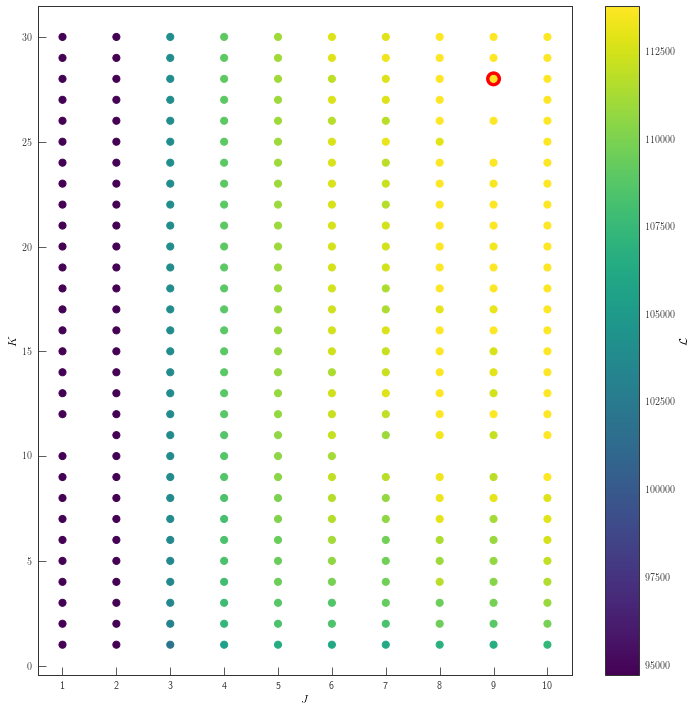

In [21]:
fig = scatter_grid_search(Js, Ks, log_likelihoods, s=50,
                          z_percentiles=[16, 84], cbar_label=r"$\mathcal{L}$",
                          highlight_z_index=-1)

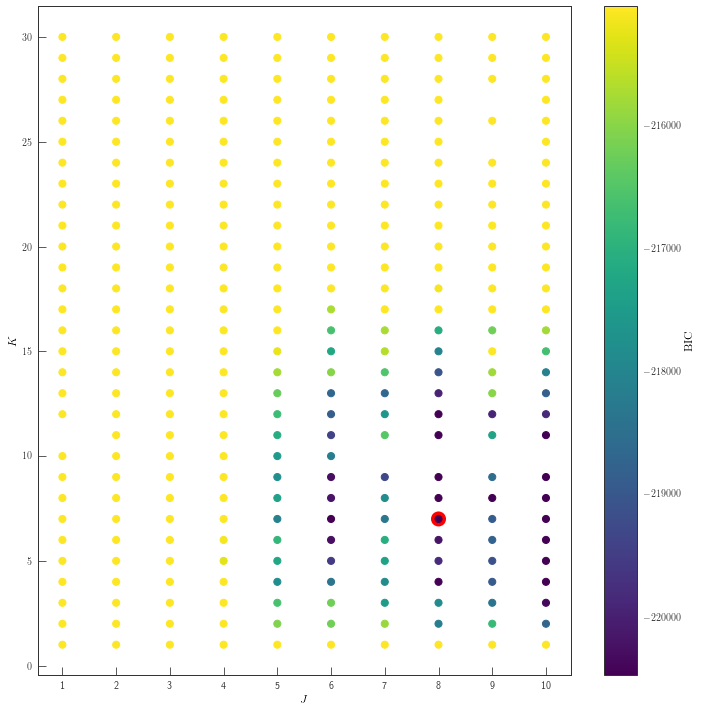

In [24]:
fig = scatter_grid_search(Js, Ks, BICs, s=50,
                          z_percentiles=[5, 30], cbar_label=r"\textrm{BIC}",
                          highlight_z_index=0)

In [25]:
model = MCFA(n_components=7, n_latent_factors=8, **mcfa_kwds)

In [26]:
model.fit(X)

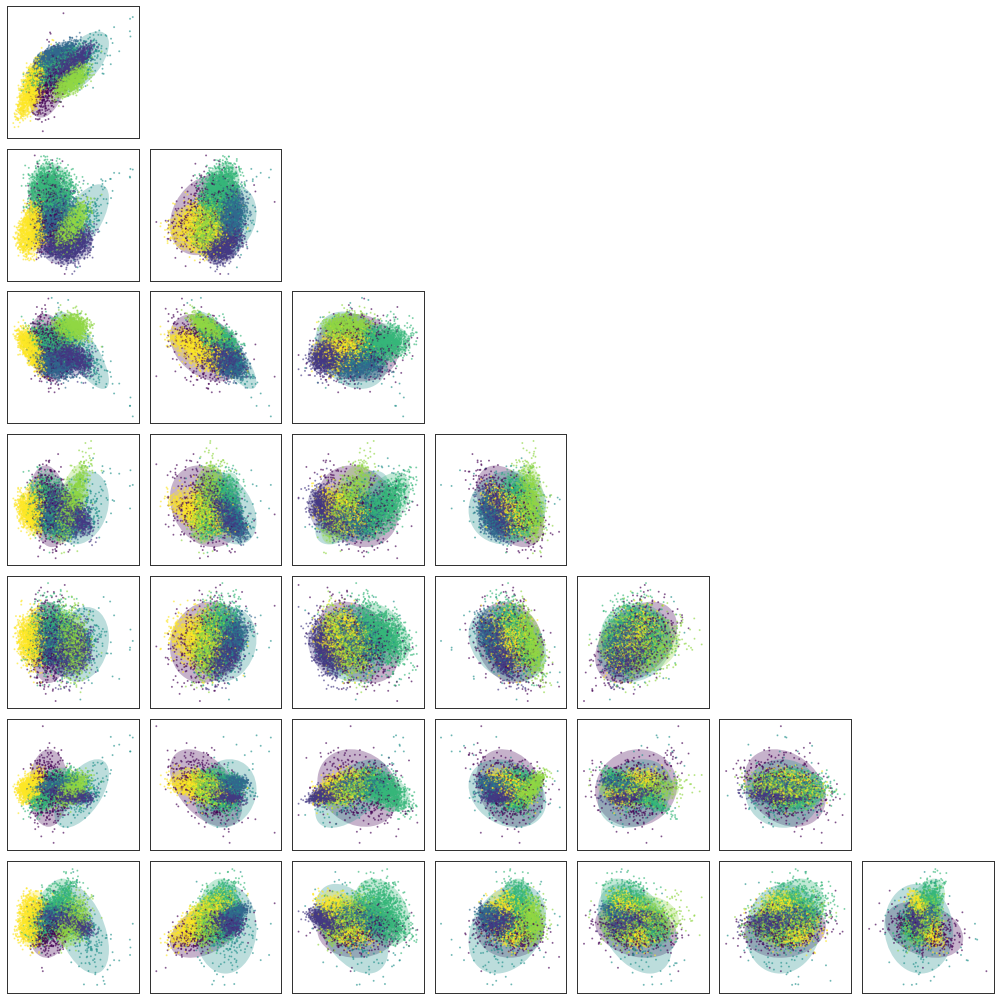

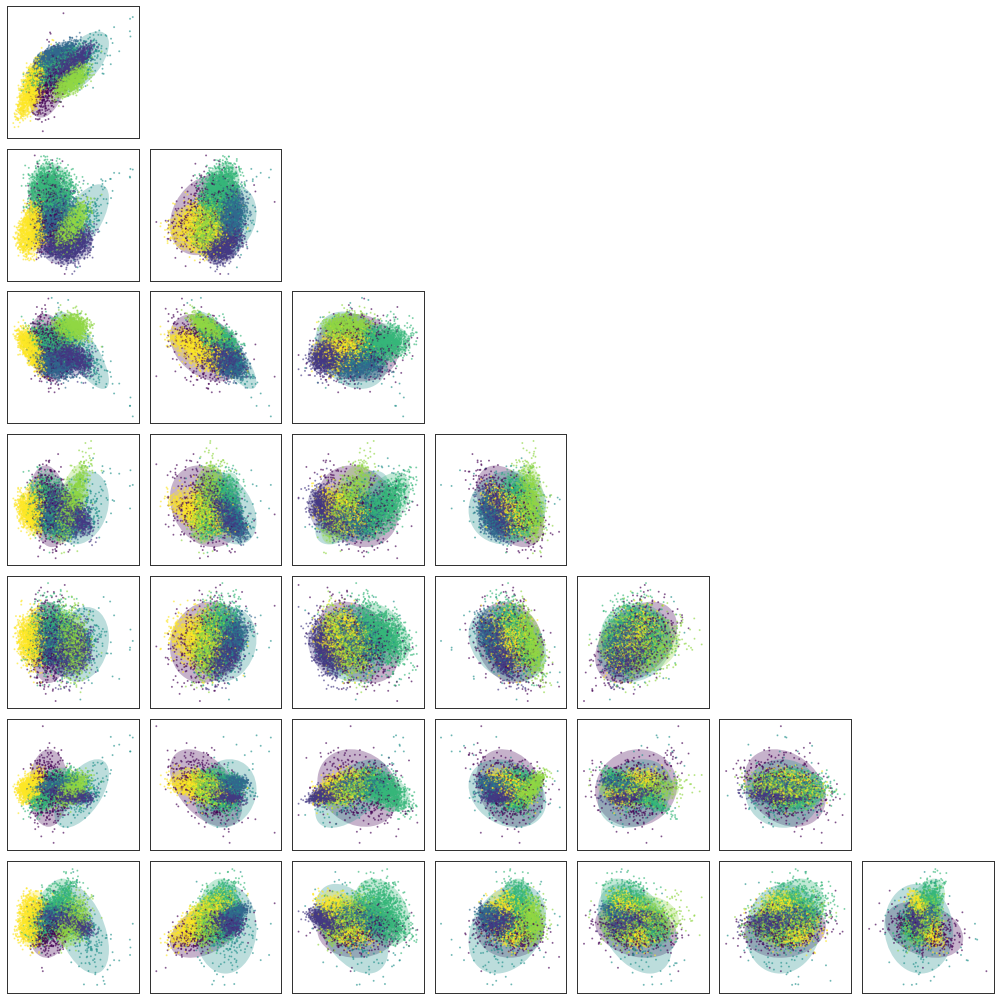

In [27]:
model.plot_latent_space(X)

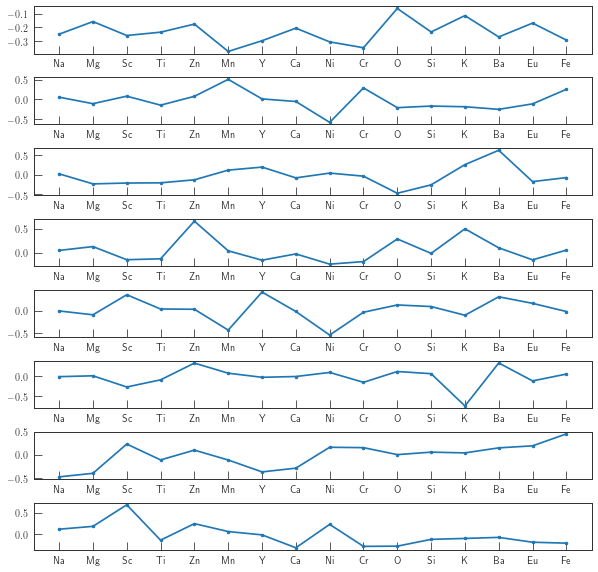

In [28]:
N, D = X.shape

latex_label_name = lambda ln: r"\textrm{{[{{{0}}}]}}".format("/".join([ln.split("_")[0].title(), ln.split("_")[1].upper()]))
latex_label_name = lambda ln: ln.split("_")[0].title()
                               
A = model.theta_[model.parameter_names.index("A")]
fig, axes = plt.subplots(model.n_latent_factors, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(A.T[i])
    ax.set_xticks(np.arange(D))
    ax.set_xticklabels([latex_label_name(ln) for ln in label_names])

In [29]:
# Group by "physics"
light_odd_z = ["Na", "K"]
fe_peak = ["Sc", "Cr", "Mn", "Fe", "Ni", "Zn"]
s_process = ["Y", "Ba"]
alpha = ["O", "Mg", "Si", "Ca", "Ti"]
r_process = ["Eu"]

ordered_label_names = light_odd_z \
                    + alpha \
                    + fe_peak \
                    + s_process \
                    + r_process
500
# ordered label indices
oli = np.array([list(label_names).index("{}_h".format(_.lower())) for _ in ordered_label_names])


assert len(set(ordered_label_names)) == len(set(label_names))



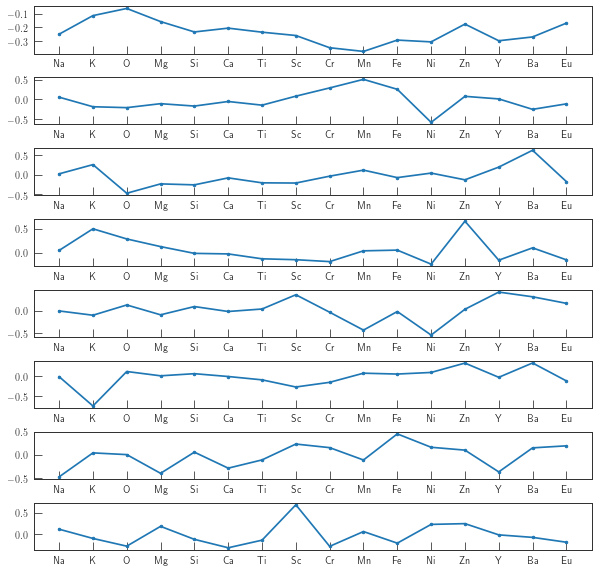

In [30]:

latex_label_name = lambda ln: ln.split("_")[0].title()
                               
A = model.theta_[model.parameter_names.index("A")]
fig, axes = plt.subplots(model.n_latent_factors, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(A.T[i][oli])
    ax.set_xticks(np.arange(D))
    ax.set_xticklabels([latex_label_name(label_names[_]) for _ in oli])
    

[Text(0,0,'Na'),
 Text(0,0,'Mg'),
 Text(0,0,'Sc'),
 Text(0,0,'Ti'),
 Text(0,0,'Zn'),
 Text(0,0,'Mn'),
 Text(0,0,'Y'),
 Text(0,0,'Ca'),
 Text(0,0,'Ni'),
 Text(0,0,'Cr'),
 Text(0,0,'O'),
 Text(0,0,'Si'),
 Text(0,0,'K'),
 Text(0,0,'Ba'),
 Text(0,0,'Eu'),
 Text(0,0,'Fe')]

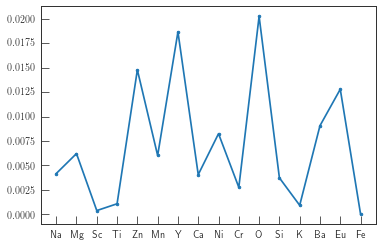

In [31]:
psi = model.theta_[model.parameter_names.index("psi")]
fig, ax = plt.subplots()
ax.plot(psi)
ax.set_xticks(np.arange(psi.size))
ax.set_xticklabels([latex_label_name(ln) for ln in label_names])

[Text(0,0,'Na'),
 Text(0,0,'K'),
 Text(0,0,'O'),
 Text(0,0,'Mg'),
 Text(0,0,'Si'),
 Text(0,0,'Ca'),
 Text(0,0,'Ti'),
 Text(0,0,'Sc'),
 Text(0,0,'Cr'),
 Text(0,0,'Mn'),
 Text(0,0,'Fe'),
 Text(0,0,'Ni'),
 Text(0,0,'Zn'),
 Text(0,0,'Y'),
 Text(0,0,'Ba'),
 Text(0,0,'Eu')]

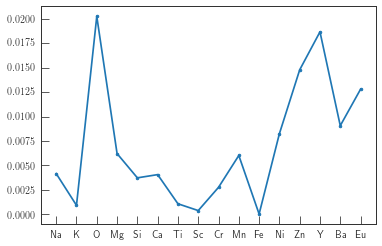

In [32]:
psi = model.theta_[model.parameter_names.index("psi")]
fig, ax = plt.subplots()
ax.plot(psi[oli])
ax.set_xticks(np.arange(psi.size))
ax.set_xticklabels([latex_label_name(label_names[_]) for _ in oli])